# Green areas, land use and population growth

Green areas in cities area important to the well being of the people living there. In this notebook, I present tools that will give insight on how the green areas are distributed around the city using postal code area data with the land use data provided by cities. This notebook uses Helsinki as an example, but the tools area applicable to other cities in Finland too. Tools also include analytics for the population growth and visualization.

In [1]:
import geopandas as gpd
import requests
import geojson
import functions as f
import folium
import numpy as np
import matplotlib.pyplot as plt

## Data fetching

// Downloading the green areas data from the WFS service provided by the City of Helsinki.
Some times the server will return an error. If this happens, the code block needs to be run again until it works. 

In [2]:
url = r"https://kartta.hel.fi/ws/geoserver/avoindata/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=avoindata:Seutukartta_maankaytto_viheralueet&outputformat=JSON"
green_areas = gpd.read_file(url)

In [5]:
url = r"https://kartta.hel.fi/ws/geoserver/avoindata/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=avoindata:Seutukartta_maankaytto_teollisuusalueet&outputformat=JSON"
industrial_areas = gpd.read_file(url)

In [8]:
url = r"https://kartta.hel.fi/ws/geoserver/avoindata/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=avoindata:Seutukartta_maankaytto_rakennetut_alueet&outputformat=JSON"
other_built_areas = gpd.read_file(url)

// Downloading the demographic data of postal code areas for 2020 and selecting the data from Helsinki 

In [9]:
# url for the postal code area statistics from 2020
url = r"http://geo.stat.fi/geoserver/postialue/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=postialue:pno_tilasto_2020&outputformat=JSON"

#setting the municipality code for Helsinki
municipality_code = '091'

# creating a variable for postal code area demographic statistics for 2020
pca_statistics_2020 = f.fetch_postal_area_data(url, municipality_code)

// Cleaning the data

In [10]:
# selecting only necessary columns
pca_statistics_2020 = pca_statistics_2020[['kunta', 'postinumeroalue', 'nimi', 'he_vakiy', 'geometry']]

# renaming columns
new_names = {'kunta': 'municipality_code', 'postinumeroalue': 'postal_code', 'nimi': 'name', 'he_vakiy': 'pop_2020'}
pca_statistics_2020 = pca_statistics_2020.rename(columns=new_names)

// Downloading the demographic data of postal code areas for 2015

In [11]:
url = r"http://geo.stat.fi/geoserver/postialue/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=postialue:pno_tilasto_2015&outputformat=JSON"

# creating a variable for postal code area demographic statistics for 2020
pca_statistics_2015 = f.fetch_postal_area_data(url, municipality_code)

// Cleaning the data:

In [12]:
# selecting only necessary columns
pca_statistics_2015 = pca_statistics_2015[['posti_alue', 'he_vakiy']]

# renaming columns
new_names = {'posti_alue': 'postal_code', 'he_vakiy': 'pop_2015'}
pca_statistics_2015 = pca_statistics_2015.rename(columns=new_names)

## Data analysis

#### Population statistics

// Merging the data

In [13]:
pca_statistics = pca_statistics_2020.merge(pca_statistics_2015, on='postal_code')

type(pca_statistics)

geopandas.geodataframe.GeoDataFrame

// Calculating the population change statistics:

In [14]:
pca_statistics = f.pop_change(pca_statistics, 'pop_2015', 'pop_2020')

In [15]:
type(pca_statistics)

geopandas.geodataframe.GeoDataFrame

#### Green area share of the postal code areas

// Calculating areas for green areas and postal code areas

In [16]:
pca_ga_statistics = f.green_areas(green_areas, pca_statistics)

In [17]:
# Cleaning the dataframe
pca_ga_statistics = pca_ga_statistics[['postal_code', 'name', 'pop_2015', 
                                    'pop_2020', 'pop_change', 'pop_change_precentage',
                                    'total_area_km2', 'green_area_km2', 'green_area_precentage', 
                                    'green_area_pc_2020_m2', 'geometry']]

#### Other land uses

In [18]:
pca_lu_statistics = f.industrial_areas(industrial_areas, pca_ga_statistics)

pca_lu_statistics = f.other_built_areas(other_built_areas, pca_lu_statistics)

In [19]:
pca_lu_statistics = f.dominant_land_use(pca_lu_statistics)

## Visualizations

#### Interactive map

In [27]:
pca_statistics_visual = pca_lu_statistics.to_crs(epsg=3857)

In [28]:
pca_statistics_visual['geoid'] = pca_lu_statistics.index.astype(str)

In [30]:
pca_statistics_visual

,postal_code,name,pop_2015,pop_2020,pop_change,pop_change_precentage,total_area_km2,green_area_km2,green_area_precentage,green_area_pc_2020_m2,geometry,industrial_area_km2,industrial_area_precentage,other_area_km2,other_area_precentage,dominant_land_use,geoid
0,00250,Taka-Töölö,10931,11359,428,3.9,3.066863,1.909283,62.3,168.1,"MULTIPOLYGON (((2772378.102 8441582.494, 27721...",0.000000,0.0,1.046026,34.1,Green area,0
1,00260,Keski-Töölö,5387,5480,93,1.7,0.752162,0.235154,31.3,42.9,"MULTIPOLYGON (((2773382.258 8438902.798, 27736...",0.000000,0.0,0.401404,53.4,Residential or commercial,1
2,00270,Pohjois-Meilahti,7546,7775,229,3.0,0.865138,0.333542,38.6,42.9,"MULTIPOLYGON (((2773032.944 8442364.420, 27730...",0.000000,0.0,0.510421,59.0,Residential or commercial,2
3,00280,Ruskeasuo,2803,2990,187,6.7,0.823059,0.385658,46.9,129.0,"MULTIPOLYGON (((2772578.767 8445817.266, 27724...",0.057886,7.0,0.379457,46.1,Green area,3
4,00290,Meilahden sairaala-alue,157,148,-9,-5.7,0.268866,0.018552,6.9,125.4,"MULTIPOLYGON (((2772761.355 8441127.930, 27729...",0.000000,0.0,0.250313,93.1,Residential or commercial,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,00940,Kontula - Vesala,25367,26010,643,2.5,5.779831,1.951494,33.8,75.0,"MULTIPOLYGON (((2794203.423 8451295.457, 27942...",0.215155,3.7,3.602742,62.3,Residential or commercial,79
80,00950,Vartioharju,5516,6060,544,9.9,3.137010,0.986386,31.4,162.8,"MULTIPOLYGON (((2795794.237 8447261.090, 27958...",0.116499,3.7,1.977479,63.0,Residential or commercial,80
81,00970,Mellunmäki,10641,10637,-4,-0.0,3.455564,1.855639,53.7,174.5,"MULTIPOLYGON (((2797135.249 8449972.732, 27998...",0.000000,0.0,1.600100,46.3,Green area,81
82,00980,Etelä-Vuosaari,22447,23183,736,3.3,10.716213,3.751015,35.0,161.8,"MULTIPOLYGON (((2799362.532 8441242.470, 27994...",2.679859,25.0,3.703732,34.6,Green area,82


In [33]:
# Create a Map instance
m = folium.Map(location=[60.19, 24.99], tiles='Stamen Toner',
                zoom_start=11, control_scale=True)

# Plot a choropleth map
folium.Choropleth(
    geo_data=pca_statistics_visual,
    name='Green area share of the postal code areas',
    data=pca_statistics_visual,
    columns=['geoid','green_area_precentage'],
    bins=5,
    threshold_scale=[0, 20, 40, 60, 80, 100],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.8,
    line_color='white', 
    line_weight=3,
    highlight=False, 
    smooth_factor=1.0,
    show=True,
    legend_name= 'Green areas (%)').add_to(m)

folium.Choropleth(
    geo_data=pca_statistics_visual,
    name='Population growth between 2015 and 2020',
    data=pca_statistics_visual,
    columns=['geoid','pop_change_precentage'],
    bins=6,
    threshold_scale=[-20, 0, 20, 50, 100, 250, 500],
    key_on='feature.id',
    fill_color="Purples",
    fill_opacity=0.8,
    line_opacity=0.8,
    line_color='white', 
    line_weight=3,
    highlight=False, 
    smooth_factor=1.0,
    show=False,
    legend_name= 'Population change (%)').add_to(m)

folium.features.GeoJson(pca_statistics_visual,  
                        name='Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip=folium.features.GeoJsonTooltip(fields=['name', 'postal_code', 'pop_change_precentage', 'green_area_precentage', 'green_area_pc_2020_m2', 'dominant_land_use'],
                                                                aliases = ['Name', 'Postal code', 'Population change (%)', 'Green area share (%)', 'Green areas per capita (m2)', 'Dominant land use'],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(m)

folium.LayerControl().add_to(m)

#Show map
m

In [34]:
outfp = "pop_growth_and_land_use_map.html"
m.save(outfp)

#### Land use visualizer

// Visualizes the land use precentages of given post code area

In [24]:
# Postal code of the are that you want to visualize (postal code as a string (ie. '00690'))
code = '00690'

# Would you like to save your plot? (Set save as True if yes)
save = True

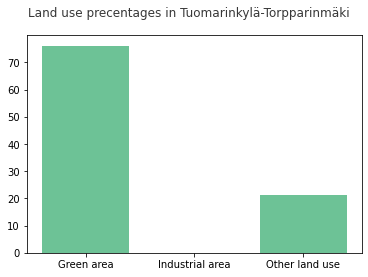

In [25]:
f.visualize_land_use(pca_lu_statistics, code, save)